In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
f = h5py.File('tec025.hdf5','r') 
train_data = np.array(f['train_mat'])
val_data = np.array(f['val_mat'])
train_data[train_data<0] = -train_data[train_data<0]
val_data[val_data<0] = -val_data[val_data<0]

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
class SAE(nn.Module):
    def __init__(self):
        super(SAE,self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1,out_channels=8,kernel_size=2,stride=2,padding=0,bias=False)
        self.conv2 = nn.Conv3d(in_channels=8,out_channels=32,kernel_size=2,stride=2,padding=0,bias=False)
        self.conv3 = nn.Conv3d(in_channels=32,out_channels=64,kernel_size=2,stride=2,padding=0,bias=False)
        self.conv4 = nn.ConvTranspose3d(in_channels=64,out_channels=32,kernel_size=2,stride=2,padding=0,bias=True)
        self.conv5 = nn.ConvTranspose3d(in_channels=32,out_channels=8,kernel_size=2,stride=2,padding=0,bias=True)
        self.conv6 = nn.ConvTranspose3d(in_channels=8,out_channels=1,kernel_size=2,stride=2,padding=0,bias=True)
    def forward(self,x):
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))
        x1 = F.relu(self.conv3(x1))
        x2 = F.relu(self.conv4(x1))
        x2 = F.relu(self.conv5(x2))
        x2 = F.relu(self.conv6(x2))
        return x1,x2

In [5]:
torch.cuda.empty_cache()

In [6]:
net = SAE().to(device)
net.load_state_dict(torch.load('UDF-AE.pkl'), strict = False)

<All keys matched successfully>

In [ ]:
#0 means the grid is passed through by a streamline in unsigned distance field and 1 means the grid is passed through by a streamline in voxel.
#So we need change the grid's value to 1 when its value is 0 in unsigned distance field and change its value to 0 when its value isn't 0 in unsigned distance field.

In [55]:
#change the value and visualize it
#visualize the original data first
ori=np.array(train_data[3]).reshape(32,32,32)
for i in range(32):
    for j in range(32):
        for k in range(32):
            if ori[i][j][k]==0:
                ori[i][j][k]=1
            else:
                ori[i][j][k]=0
print(ori[ori==1].shape)

(48,)


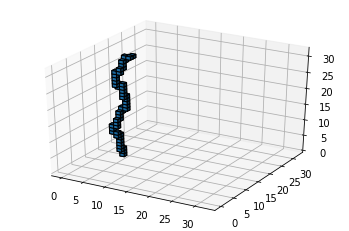

In [56]:
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
ax.voxels(ori,edgecolor='k')
plt.show()

In [57]:
#gain the output data in unsignde distance field format
show = torch.Tensor(train_data[3])
show = show.view(1,1,32,32,32)
show = show.to(device)
out1,out2 = net(show)
out = np.array(out2.data.cpu()).reshape(32,32,32)
print(out[out==0].shape)

(38,)


In [ ]:
#Because the autoencoder cannot completely output the same value as the original data so a very small value in output data may represent 0 in the original data of the same grid.
#So you need to set a threshold to define what is 'very small'.

In [59]:
#set the threshold
print(out[out<0.2].shape)

(55,)


In [60]:
#visualize the output data 
for i in range(32):
    for j in range(32):
        for k in range(32):
            if out[i][j][k]<0.2:
                out[i][j][k]=1
            else:
                out[i][j][k]=0

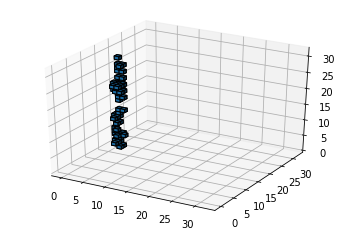

In [61]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(out,edgecolor='k')
plt.show()